In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/poem-generation/poem.txt


In [5]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import spacy, random
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences

In [6]:
def read_file(filepath):
    with open(filepath,'r') as f:
        text = f.read()
    
    return text

In [7]:
poem = read_file('../input/poem-generation/poem.txt')

In [8]:
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 20000000

In [9]:
def clean_text(text):
    return [token.text.lower() for token in nlp(text) if token.text not in '\n\n \n\n\n --!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n']

In [10]:
tokens = clean_text(poem)

In [11]:
train_len = 25 + 1
text_sequences = []

for i in range(train_len,len(tokens)):
    text_sequences.append(tokens[i-train_len:i])

In [12]:
len(text_sequences)

19047

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)

In [14]:
' '.join(text_sequences[random.randint(0,len(text_sequences))])

'to know i was leaving forever the land of my soul amid struggle and fear my parents did pray to place courage to leave oer the'

In [15]:
sequences = tokenizer.texts_to_sequences(text_sequences)

In [16]:
np.shape(sequences)

(19047, 26)

In [17]:
sequences = np.array(sequences)
sequences.shape

(19047, 26)

In [18]:
X = sequences[:,:-1]
y = sequences[:,-1]

In [19]:
vocabulary_size = len(tokenizer.word_counts)
vocabulary_size

3750

In [20]:
y = to_categorical(y,num_classes=vocabulary_size+1)

In [21]:
y.shape

(19047, 3751)

In [22]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
seq_len = X.shape[1]

In [24]:
seq_len

25

In [25]:
def create_model(vocabulary_size,seq_len):
    model = Sequential()
    model.add(Embedding(input_dim=vocabulary_size,output_dim=seq_len,input_length=seq_len))
    model.add(LSTM(units=150,return_sequences=True))
    model.add(LSTM(units=150,return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(LSTM(units=300))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(units=150,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(units=vocabulary_size,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
    model.summary()
    return model

In [26]:
model = create_model(vocabulary_size+1,seq_len)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 25)            93775     
_________________________________________________________________
lstm (LSTM)                  (None, 25, 150)           105600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 150)           180600    
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 150)           600       
_________________________________________________________________
dropout (Dropout)            (None, 25, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               541200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1

In [27]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=300,verbose=1,mode='max',restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=10,mode='max',factor=0.1,min_lr=0.001,verbose=1)
model_checkpoint = ModelCheckpoint('checkpoint/',monitor='val_accuracy',mode='max',save_best_only=True,save_weights_only=True,verbose=1)

r = model.fit(X_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=2,
          validation_data=(X_test,y_test),
          callbacks=[model_checkpoint,reduce_lr,early_stopping])

Epoch 1/100
105/105 - 11s - loss: 8.1214 - accuracy: 0.0257 - val_loss: 7.8475 - val_accuracy: 0.0626

Epoch 00001: val_accuracy improved from -inf to 0.06264, saving model to checkpoint/
Epoch 2/100
105/105 - 2s - loss: 7.2853 - accuracy: 0.0566 - val_loss: 7.3154 - val_accuracy: 0.0626

Epoch 00002: val_accuracy did not improve from 0.06264
Epoch 3/100
105/105 - 2s - loss: 6.5623 - accuracy: 0.0668 - val_loss: 7.0689 - val_accuracy: 0.0616

Epoch 00003: val_accuracy did not improve from 0.06264
Epoch 4/100
105/105 - 2s - loss: 6.2629 - accuracy: 0.0718 - val_loss: 7.0816 - val_accuracy: 0.0600

Epoch 00004: val_accuracy did not improve from 0.06264
Epoch 5/100
105/105 - 2s - loss: 6.0945 - accuracy: 0.0744 - val_loss: 7.1220 - val_accuracy: 0.0632

Epoch 00005: val_accuracy improved from 0.06264 to 0.06317, saving model to checkpoint/
Epoch 6/100
105/105 - 2s - loss: 5.9374 - accuracy: 0.0776 - val_loss: 7.2384 - val_accuracy: 0.0483

Epoch 00006: val_accuracy did not improve from 0.

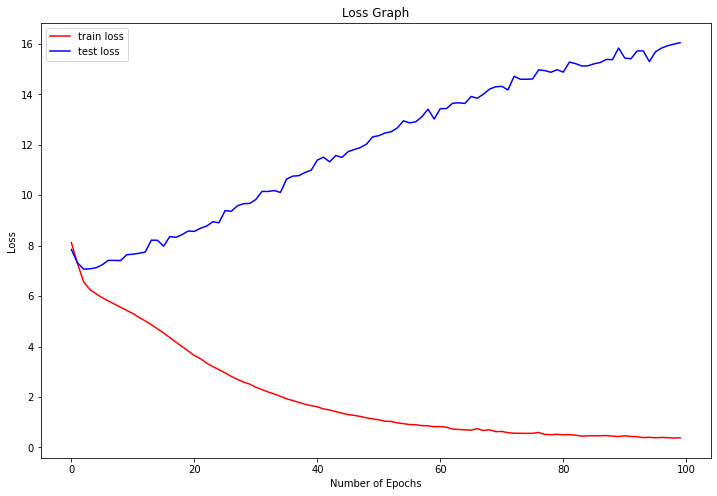

In [28]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

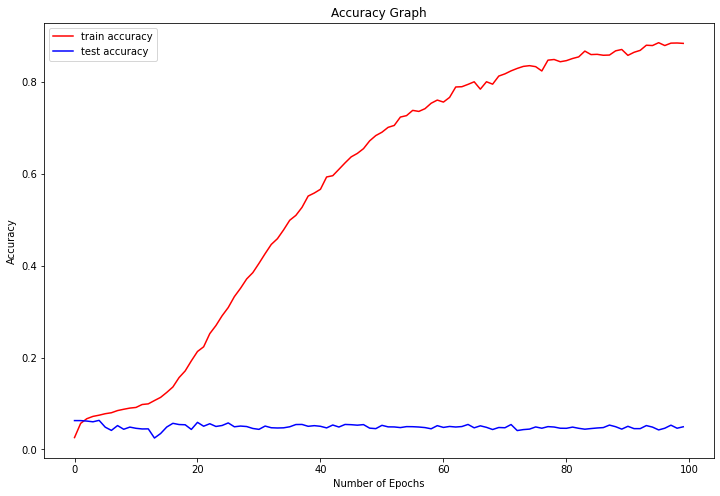

In [29]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [30]:
model.evaluate(X_test,y_test)

179/179 [==============================] - 1s 6ms/step - loss: 16.0463 - accuracy: 0.0492


[16.046314239501953, 0.04916885495185852]

In [31]:
model.save('literature_generator.h5')

In [32]:
lstm = load_model('literature_generator.h5')
lstm

In [43]:
def generate_text(model,tokenizer,seq_len,seed_text,num_words):
    output_text = []
    input_text = seed_text
    
    for i in range(num_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        padded_text = pad_sequences([encoded_text],maxlen=seq_len,truncating='pre')
        predictions = model.predict(padded_text,verbose=0)[0]
        pred_word = tokenizer.index_word[predictions.argmax()]
        input_text += ' ' + pred_word
        output_text.append(pred_word)
    
    return ' '.join(output_text)

In [44]:
for i in range(10):
    random_seed_text = ' '.join(text_sequences[random.randint(0,len(text_sequences))])
    print(generate_text(lstm,tokenizer,seq_len,random_seed_text,num_words=25))

i our bow fought for swell danced in a swell danced to unexpected to bowl of warns to warns the punctual warns the moon men
and a flower flower a flower bell ringing revenge and longer of the sun time sand away for your touch and not not moving n't
and in your war and captive slave for do do no do or desolate but good dear take your chain they love more will no
home it is is the best it we can turn a trial why calls with the face is the difference waiting of wrapped to old
my delight thou my souls shelter thou high high tower raise thou me heavenward high power of my power riches i i not nor mans
true true lover no lover do but with do do but ever ever but with going with home between warm but and no good living
prince edward edward waiting an a ball of a chisel one and marchin a pipers flashed in the pipers of claim of a man too
will play the more rover no more sounds the harm eye and never alas i never was take up and the boys grow it lie
a paradise to a paradise to the maid malone f

IndexError: list index out of range

In [45]:
print(generate_text(lstm,tokenizer,seq_len,'once upon a time',num_words=50))

good wives jest of this brave at the wives fearless is fearless and fall are fall how the red ’s coat coat country within the town is gone is slavery for irish first is the world far is drowsily difference gone of april every april every world seems spite and


In [46]:
print(generate_text(lstm,tokenizer,seq_len,'you belong',num_words=50))

good good jar grave hiccough like the envy and a man chieftains who o’er laughters is sweet is is has even your face and much toward toward you unsurpassed in the stars on the claiming song and the glimmering and the banks and s was young foolish and i took


In [47]:
print(generate_text(lstm,tokenizer,seq_len,'I wandered lonely as a cloud',num_words=100))

at men and do if if danny found i call nt nt going the call of girls all the barn of barn and shining spent in a shocking wet an shocking mad i was her was tree and i was standing from the first was then she smiled and was the sky but his weirs malone i was his salley lad and she was threw and she gear and was the vision of she was gardens and rest i gear and her wheels the sweet of saw and she can rose like the summer time was time grow and time
